#  EDA
## Overview

Below is draft EDA.  Starting from the original 'Data Storytelling' sheets, we'll use the functions and dataframes from that as a starting point.

#The story of poverty in New York City is primarily about people and income. Within that, a wide variety of factors such as age, location, disability status, ability to speak English, the size and composition of an apartment or home -- even factors that the data only hint at -- play a key role.

#We'll look quickly at the dataset, do a little housekeeping, and then jump into the visualizations with comments.

#Note that, since our dataset has annual data from 2005-2016, most of these charts will be time slices from 2005, 2010, and 2016 for comparison across time.

## The Dataset

* Data from https://data.cityofnewyork.us/browse?q=poverty
* 12 annual data files, from 2005 to 2016 inclusive (e.g. NYCgov_Poverty_Measure_Data__2016_.csv)
* CSV files with ~80 columns and ~60,000 rows each
* Each file had essentially the same format and contained (mostly) the same information
* Data types included:
    * Classification types encoded as integers (e.g. 1 if in poverty, 2 if not in poverty)
    * Floats for financial data (e.g. wages for the calendar year)

## Housekeeping part 1: imports and file prep

In order to make charts more easily, after importing we'll make some quick modifications to the data.

In [96]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, hsv_to_rgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chisquare
from statsmodels.stats.weightstats import DescrStatsW

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)

# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

# Create a dataframe 'cats' that uses categorical coding, rather than numerical coding, based on the dictionaries above.
cats = df.replace(nyc_codes)
cats = cats.replace(raw_codes)
cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 
                     'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}, 
                     'AgeCateg': {1: 'U18', 2:'18-64', 3:'65+'}})

# Update one column so that NA's are all in one category
cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
#per_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'NYCgov_EITC', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork'] 
#hh_vars = ['MRGP_adj', 'RNTP_adj', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'Off_Threshold', 'Off_Pov_Stat', 'PWGTP', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']
#other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP', 'Year']

#old_per_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork'] 
#old_hh_vars = ['NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']
#old_other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Off_Pov_Stat', 'Off_Threshold', 'PWGTP', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP', 'Year']



In [ ]:
# Many variables are actually categorical variables, but are represented by numbers
# Here we'll split out which are really categorical, and which are really numeric
#categorical_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork']
#numeric_vars = ['NYCgov_EITC', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', ]
#household_vars = ['NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'WGTP', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', ]
#other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year', 'PWGTP', ]

In [32]:
# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
personal_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'NYCgov_EITC', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'PWGTP', 'FTPTWork'] 
household_vars = ['MRGP_adj', 'RNTP_adj', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'WGTP', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']
other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year']

## Housekeeping part 2: helper functions

In [4]:
def df_for_pov_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of weighted poverty rate by a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

def df_for_pov_chart_nocats(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe (from a dataframe of numeric-only categories) of weighted poverty rate by 
    a single category in a column. 
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 1, ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    pcts = pcts.rename(columns={1: 'Pov', 2: 'No Pov'})
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

def df_for_stat_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', [column, weights_column]].groupby(column).sum()
    else:
        counts = dataframe[[column, weights_column]].groupby(column).sum()
        
    # count and create % by column    
    subtotals = counts.sum(level=0)
    pcts = subtotals/sum(counts[weights_column])
    
    # only return the % in poverty by column
    return pcts

def scatter_combined(dataframe, column, ylim=35):
    '''Create a scatter plot of weighted poverty rate by a single column, all years combined.
    Input: a dataframe, a column name, and an optional upper y-limit for the chart.
    Output: no return value. Plots a scatter plot.'''
    
    # Set up initial variables
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create counts and percentages by column
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts = pcts.rename(columns={'Pov': 'Weighted Poverty Rate by ' + str(column) + ', All Years Combined'})

    # Show the chart
    chart = sns.scatterplot(data=pcts)
    chart.set_ylim(0,ylim)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    pass

def scatter_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple scatter plots of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
            
def scatter_sub_stat(dataframe, column, years=[2005, 2010, 2016], ylimits=[0,0.25]):
    '''Create multiple scatter plots of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y=weight, title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()])
            ax.set_ylim(ylimits[0], ylimits[1])
            
def bar_combined(dataframe, column):
    '''Create a bar chart of weighted poverty rate by a single column, all years combined.
    Input: a dataframe and a column name.
    Output: no return value. Plots a bar chart.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts.plot.bar(title='Weighted Poverty Rate by ' + str(column) + ', All Years Combined', legend=None, color='bgrcymk')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    
def bar_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
        
def bar_sub_stat(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=len(years), figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(len(years))):
        pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

In [5]:
def ecdf(x):
    return np.arange(1, len(x)+1) / len(x)

def ecdf_plot(x):
    x_sorted = sorted(x)
    plt.plot(x_sorted, ecdf(x_sorted), marker='.', linestyle='none')

hhonly_2016 = df.loc[(df.Year == 2016) & (df.Povunit_Rel == 1)].copy()

## The Poverty Calculation

* New York City has its own poverty calculation, detailed at https://www1.nyc.gov/site/opportunity/poverty-in-nyc/poverty-measure.page
* The poverty calculation is **NYCgov_Income vs NYCgov_Threshold**


* **NYCgov_Threshold** is the official US poverty threshold ('Off_Threshold'), with an adjustment for housing costs
    * The official poverty threshold is set by the US government, and the housing cost calculation is intended to compensate for the higher cost of housing in New York City 
    * **We will consider the NYC poverty threshold as fixed for each particular household for purposes of our analysis**, since the data to compute the housing cost adjustment is not available
        * The calculations of the threshold and the housing cost adjustment are summarized at https://www1.nyc.gov/assets/opportunity/pdf/Appendix%20B%20-%20NYCgovPovMeas18.pdf and https://www1.nyc.gov/assets/opportunity/pdf/Appendix%20C%20-%20NYCgovPovMeas18.pdf
    
    
* **NYCgov_Income** is income minus costs: 
    
    **(PreTaxIncome_PU – NYCgov_IncomeTax – NYCgov_FICAtax) +
    (NYCgov_SNAP + NYCgov_WIC + NYCgov_SchoolBreakfast + NYCgov_SchoolLunch) +
    NYCgov_HEAP +
    NYCgov_Housing -
    (NYCgov_Commuting + NYCgov_Childcare + NYCgov_MOOP)**


* Note that in the terms above, the prefix 'NYCgov_' simply means that this value was calculated by the NYC Poverty Research team.  It does not necessarily mean that the government of NYC has any impact on the value.

So, which variables have the most impact on NYCgov_Income? As we can see below, 

In [175]:
tester = df.copy()
tester = tester.loc[(tester.Year == 2016), ['SERIALNO', 'NYCgov_Income', 'PreTaxIncome_PU', 'NYCgov_IncomeTax', 'NYCgov_FICAtax', 'NYCgov_SNAP', 'NYCgov_WIC', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Commuting', 'NYCgov_Childcare', 'NYCgov_MOOP', 'WGTP']]
tester2 = tester.loc[:, ['SERIALNO', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_FICAtax', 'NYCgov_SNAP', 'NYCgov_WIC', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Commuting', 'NYCgov_Childcare', 'NYCgov_MOOP']].groupby('SERIALNO').sum()
tester2['PreTax_IncomePU'] = tester.groupby('SERIALNO').mean().PreTaxIncome_PU
no_wgtp = tester2.copy()
tester2['WGTP'] = tester.groupby('SERIALNO').mean().WGTP

pd.DataFrame(DescrStatsW(no_wgtp, tester2.WGTP).corrcoef, index=no_wgtp.columns, columns=no_wgtp.columns).NYCgov_Income.sort_values(ascending=False)

NYCgov_Income             1.000000
NYCgov_FICAtax            0.936678
NYCgov_IncomeTax          0.838286
PreTax_IncomePU           0.749019
NYCgov_MOOP               0.561718
NYCgov_Commuting          0.466781
NYCgov_Housing            0.237502
NYCgov_Childcare          0.237221
NYCgov_SNAP               0.208043
NYCgov_SchoolLunch        0.153632
NYCgov_HEAP               0.139919
NYCgov_WIC                0.105267
NYCgov_SchoolBreakfast    0.060547
Name: NYCgov_Income, dtype: float64

In [210]:
tester = df.loc[df.Year == 2016, ['SERIALNO', 'WGTP']].copy()
tester['Tuple'] = pd.Series([tuple(x) for x in tester.values], index=tester.index)
tester[:15]
#tuples = list(tester['Tuple'])
#tuples[:15]
#unnamed = pd.Series([tuple(x) for x in tester.values])
#unnamed[:15]

#tuples.sort(lambda x: x[1]).unique().head()
#tuples.sort(key=lambda tup: tup[1]) 

,SERIALNO,WGTP,Tuple
710612,39,52,"(39, 52)"
710613,55,30,"(55, 30)"
710614,55,30,"(55, 30)"
710615,55,30,"(55, 30)"
710616,55,30,"(55, 30)"
710617,55,30,"(55, 30)"
710618,69,192,"(69, 192)"
710619,210,38,"(210, 38)"
710620,261,150,"(261, 150)"
710621,261,150,"(261, 150)"


In [ ]:
tester = df.copy()
tester = tester.loc[(tester.Year == 2016), ['Pre_Tax_IncomePU'] + personal_vars]
tester2 = tester.loc[:, ['SERIALNO', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_FICAtax', 'NYCgov_SNAP', 'NYCgov_WIC', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Commuting', 'NYCgov_Childcare', 'NYCgov_MOOP']].groupby('SERIALNO').sum()
tester2['PreTax_IncomePU'] = tester.groupby('SERIALNO').mean().PreTaxIncome_PU
no_wgtp = tester2.copy()
tester2['WGTP'] = tester.groupby('SERIALNO').mean().WGTP

pd.DataFrame(DescrStatsW(no_wgtp, tester2.WGTP).corrcoef, index=no_wgtp.columns, columns=no_wgtp.columns).NYCgov_Income.sort_values(ascending=False)

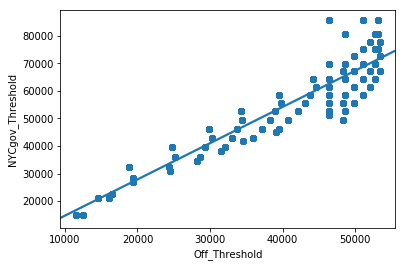

In [91]:
#df[['NYCgov_Threshold', 'Off_Threshold']].corr()
df.loc[(df.Year == 2016), ['NYCgov_Threshold', 'Off_Threshold']].corr()
#df.loc[(df.Year == 2016), ['NYCgov_Threshold', 'Off_Threshold']].plot(kind='scatter', x='Off_Threshold', y='NYCgov_Threshold')
sns.regplot(data=df.loc[(df.Year == 2016), ['NYCgov_Threshold', 'Off_Threshold']], x='Off_Threshold', y='NYCgov_Threshold')
#diffs = df.NYCgov_Threshold - df.Off_Threshold
#diffs.sum()/len(diffs)

In [6]:
# Columns to drop: NYCgov_Nutrition
# 
hhonly_2016['Test_nutrition'] = hhonly_2016.NYCgov_SNAP + hhonly_2016.NYCgov_WIC + hhonly_2016.NYCgov_SchoolBreakfast + hhonly_2016.NYCgov_SchoolLunch
hhonly_2016['Test_MOOP'] = hhonly_2016.NYCgov_MedPremiums + hhonly_2016.NYCgov_MedSpending
hhonly_2016['Test_costs'] = hhonly_2016.MRGP_adj + hhonly_2016.RNTP_adj + hhonly_2016.NYCgov_Childcare + hhonly_2016.NYCgov_Commuting + hhonly_2016.NYCgov_FICAtax + hhonly_2016.NYCgov_IncomeTax + hhonly_2016.NYCgov_MOOP
#hhonly_2016['Test_Income'] = -hhonly_2016.Test_costs + hhonly_2016.INTP_adj + hhonly_2016.OI_adj + hhonly_2016.PA_adj + hhonly_2016.RETP_adj + hhonly_2016.SEMP_adj + hhonly_2016.SSIP_adj + hhonly_2016.SSP_adj +  hhonly_2016.WAGP_adj + hhonly_2016.NYCgov_EITC + hhonly_2016.NYCgov_HEAP + hhonly_2016.NYCgov_Housing + hhonly_2016.NYCgov_SNAP + hhonly_2016.NYCgov_WIC + hhonly_2016.NYCgov_SchoolBreakfast + hhonly_2016.NYCgov_SchoolLunch
hhonly_2016['Test_Income'] =  (hhonly_2016.PreTaxIncome_PU - hhonly_2016.NYCgov_IncomeTax - hhonly_2016.NYCgov_FICAtax) + (hhonly_2016.NYCgov_SNAP + hhonly_2016.NYCgov_WIC + hhonly_2016.NYCgov_SchoolBreakfast + hhonly_2016.NYCgov_SchoolLunch) + hhonly_2016.NYCgov_HEAP + hhonly_2016.NYCgov_Housing - (hhonly_2016.NYCgov_Commuting + hhonly_2016.NYCgov_Childcare + hhonly_2016.NYCgov_MOOP)

#only2016['Test_Income'] = -only2016.Test_costs + only2016.INTP_adj + only2016.OI_adj + only2016.PA_adj + only2016.RETP_adj + only2016.SEMP_adj + only2016.SSIP_adj + only2016.SSP_adj +  only2016.WAGP_adj + only2016.NYCgov_HEAP + only2016.NYCgov_Housing + only2016.NYCgov_SNAP + only2016.NYCgov_WIC + only2016.NYCgov_SchoolBreakfast + only2016.NYCgov_SchoolLunch
#id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
test_income = ['NYCgov_Income', 'INTP_adj', 'OI_adj', 'PA_adj', 'RETP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj', 'NYCgov_EITC', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Nutrition', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_WIC']
test_income_small = ['INTP_adj', 'OI_adj', 'PA_adj', 'RETP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj', 'NYCgov_EITC', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_Nutrition' ]
test_cost = ['MRGP_adj', 'RNTP_adj', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', ]
other_vars = ['INTP_adj', 'OI_adj', 'PA_adj', 'RETP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj', 'NYCgov_EITC', 'NYCgov_Nutrition', 'MRGP_adj', 'RNTP_adj', 'NYCgov_MedPremiums', 'NYCgov_MedSpending']
# NYCgov_Income = (PreTaxIncome_PU – NYCgov_IncomeTax – NYCgov_FICAtax) + (NYCgov_SNAP + NYCgov_WIC + NYCgov_SchoolBreakfast + NYCgov_SchoolLunch) + NYCgov_HEAP + NYCgov_Housing - (NYCgov_Commuting + NYCgov_Childcare + NYCgov_MOOP)
#test_threshold = ['NP', 'Off_Threshold', 'FamType_PU', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_Threshold', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
#test_other = ['PreTaxIncome_PU']

nutrition_test = np.allclose(hhonly_2016.Test_nutrition, hhonly_2016.NYCgov_Nutrition, 1)
moop_test = np.allclose(hhonly_2016.Test_MOOP, hhonly_2016.NYCgov_MOOP, 0.01)
income_test = np.allclose(hhonly_2016.Test_Income, hhonly_2016.NYCgov_Income, 1)

print('Nutrition: ' + str(nutrition_test))
print('MOOP: ' + str(moop_test))
print('Income: ' + str(income_test))
print(len(hhonly_2016))
#print(only2016.loc[only2016.Test_Income > 1 + only2016.NYCgov_Income, ['SERIALNO', 'SPORDER', 'Povunit_Rel', 'Test_Income', 'NYCgov_Income']].head(15))
print('Test is higher: ' + str(len(hhonly_2016.loc[hhonly_2016.Test_Income > 1 + hhonly_2016.NYCgov_Income])))
print('Test is lower: ' + str(len(hhonly_2016.loc[hhonly_2016.Test_Income < -1 + hhonly_2016.NYCgov_Income])))
print('Unequal: ' + str(len(hhonly_2016.loc[hhonly_2016.Test_Income != hhonly_2016.NYCgov_Income])))
print('Max: ' + str(np.max(hhonly_2016.Test_Income - hhonly_2016.NYCgov_Income)))
#print(len(hhonly_2016.loc[hhonly_2016.Test_Income < -1 + hhonly_2016.NYCgov_Income]))
#print(hhonly_2016.loc[hhonly_2016.Test_Income > 1 + hhonly_2016.NYCgov_Income, ['Test_Income'] + test_income + test_cost].head().T)
#print(hhonly_2016.loc[hhonly_2016.Test_Income > 1 + hhonly_2016.NYCgov_Income, ['Test_Income'] + test_income].head())
#print(hhonly_2016.loc[hhonly_2016.Test_Income > 1 + hhonly_2016.NYCgov_Income, test_cost].head())

Nutrition: False
MOOP: True
Income: True
29595
Test is higher: 0
Test is lower: 0
Unequal: 17812
Max: 9.313225746154785e-10


In [52]:
#hhonly_2016['Test_nutrition'] = hhonly_2016.NYCgov_SNAP + hhonly_2016.NYCgov_WIC + hhonly_2016.NYCgov_SchoolBreakfast + hhonly_2016.NYCgov_SchoolLunch
#hhonly_2016['Test_MOOP'] = hhonly_2016.NYCgov_MedPremiums + hhonly_2016.NYCgov_MedSpending
#hhonly_2016['Test_costs'] = hhonly_2016.MRGP_adj + hhonly_2016.RNTP_adj + hhonly_2016.NYCgov_Childcare + hhonly_2016.NYCgov_Commuting + hhonly_2016.NYCgov_FICAtax + hhonly_2016.NYCgov_IncomeTax + hhonly_2016.NYCgov_MOOP
#hhonly_2016['Test_Income'] = -hhonly_2016.Test_costs + hhonly_2016.INTP_adj + hhonly_2016.OI_adj + hhonly_2016.PA_adj + hhonly_2016.RETP_adj + hhonly_2016.SEMP_adj + hhonly_2016.SSIP_adj + hhonly_2016.SSP_adj +  hhonly_2016.WAGP_adj + hhonly_2016.NYCgov_EITC + hhonly_2016.NYCgov_HEAP + hhonly_2016.NYCgov_Housing + hhonly_2016.NYCgov_SNAP + hhonly_2016.NYCgov_WIC + hhonly_2016.NYCgov_SchoolBreakfast + hhonly_2016.NYCgov_SchoolLunch

#only2016['Test_Income'] = -only2016.Test_costs + only2016.INTP_adj + only2016.OI_adj + only2016.PA_adj + only2016.RETP_adj + only2016.SEMP_adj + only2016.SSIP_adj + only2016.SSP_adj +  only2016.WAGP_adj + only2016.NYCgov_HEAP + only2016.NYCgov_Housing + only2016.NYCgov_SNAP + only2016.NYCgov_WIC + only2016.NYCgov_SchoolBreakfast + only2016.NYCgov_SchoolLunch
#id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
test_income = ['INTP_adj', 'OI_adj', 'PA_adj', 'RETP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj', 'NYCgov_EITC', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_Nutrition', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_WIC', ]
test_income_small = ['INTP_adj', 'OI_adj', 'PA_adj', 'RETP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj', 'NYCgov_EITC', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_Nutrition' ]
test_cost = ['MRGP_adj', 'RNTP_adj', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', ]
#test_threshold = ['NP', 'Off_Threshold', 'FamType_PU', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_Threshold', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
#test_other = ['PreTaxIncome_PU']

#nutrition_test = np.allclose(hhonly_2016.Test_nutrition, hhonly_2016.NYCgov_Nutrition, 1)
#moop_test = np.allclose(hhonly_2016.Test_MOOP, hhonly_2016.NYCgov_MOOP, 0.01)
#income_test = np.allclose(hhonly_2016.Test_Income, hhonly_2016.NYCgov_Income, 1)

#print('Nutrition: ' + str(nutrition_test))
#print('MOOP: ' + str(moop_test))
#print('Income: ' + str(income_test))
#print(len(hhonly_2016))
#print(only2016.loc[only2016.Test_Income > 1 + only2016.NYCgov_Income, ['SERIALNO', 'SPORDER', 'Povunit_Rel', 'Test_Income', 'NYCgov_Income']].head(15))
#print(len(hhonly_2016.loc[hhonly_2016.Test_Income < -1 + hhonly_2016.NYCgov_Income]))
#print(hhonly_2016.loc[hhonly_2016.Test_Income > 1 + hhonly_2016.NYCgov_Income, ['Test_Income'] + test_income].head())
#print(hhonly_2016.loc[hhonly_2016.Test_Income > 1 + hhonly_2016.NYCgov_Income, test_cost].head())

only2016 = df[df.Year == 2016].copy()
#only2016['Test_nutrition'] = only2016.NYCgov_SNAP + only2016.NYCgov_WIC + only2016.NYCgov_SchoolBreakfast + only2016.NYCgov_SchoolLunch
#only2016['Test_MOOP'] = only2016.NYCgov_MedPremiums + only2016.NYCgov_MedSpending
#only2016['Test_costs'] = only2016.MRGP_adj + only2016.RNTP_adj + only2016.NYCgov_Childcare + only2016.NYCgov_Commuting + only2016.NYCgov_FICAtax + only2016.NYCgov_IncomeTax + only2016.NYCgov_MOOP
#only2016['Test_Income'] = -only2016.Test_costs + only2016.INTP_adj + only2016.OI_adj + only2016.PA_adj + only2016.RETP_adj + only2016.SEMP_adj + only2016.SSIP_adj + only2016.SSP_adj +  only2016.WAGP_adj + only2016.NYCgov_EITC + only2016.NYCgov_HEAP + only2016.NYCgov_Housing + only2016.NYCgov_SNAP + only2016.NYCgov_WIC + only2016.NYCgov_SchoolBreakfast + only2016.NYCgov_SchoolLunch
#only2016['Test_Income'] = -only2016.Test_costs + only2016.INTP_adj + only2016.OI_adj + only2016.PA_adj + only2016.RETP_adj + only2016.SEMP_adj + only2016.SSIP_adj + only2016.SSP_adj +  only2016.WAGP_adj + only2016.NYCgov_HEAP + only2016.NYCgov_Housing + only2016.NYCgov_SNAP + only2016.NYCgov_WIC + only2016.NYCgov_SchoolBreakfast + only2016.NYCgov_SchoolLunch
only2016['Test_Income'] = (only2016.PreTaxIncome_PU - only2016.NYCgov_IncomeTax - only2016.NYCgov_FICAtax) + (only2016.NYCgov_SNAP + only2016.NYCgov_WIC + only2016.NYCgov_SchoolBreakfast + only2016.NYCgov_SchoolLunch) + only2016.NYCgov_HEAP + only2016.NYCgov_Housing - (only2016.NYCgov_Commuting + only2016.NYCgov_Childcare + only2016.NYCgov_MOOP)
#only2016.NYCgov_Nutrition 

#nutrition_test = np.sum(np.allclose(only2016.Test_nutrition, only2016.NYCgov_Nutrition))
#nutrition_test = np.allclose(only2016.Test_nutrition, only2016.NYCgov_Nutrition, 1)
#moop_test = np.allclose(only2016.Test_MOOP, only2016.NYCgov_MOOP, 0.01)
income_test = np.allclose(only2016.Test_Income, only2016.NYCgov_Income, 1)

#print('Nutrition: ' + str(nutrition_test))
#print('MOOP: ' + str(moop_test))
print('Income: ' + str(income_test))
#print(len(only2016))
##print(only2016.loc[only2016.Test_Income > 1 + only2016.NYCgov_Income, ['SERIALNO', 'SPORDER', 'Povunit_Rel', 'Test_Income', 'NYCgov_Income']].head(15))
#print(len(only2016.loc[only2016.Test_Income < -1 + only2016.NYCgov_Income]))
#print(only2016.loc[only2016.Test_Income > 1 + only2016.NYCgov_Income, ['Test_Income'] + test_income].head())
#print(only2016.loc[only2016.Test_Income > 1 + only2016.NYCgov_Income, test_cost].head())
#print(only2016.loc[only2016.Test_nutrition == only2016.NYCgov_Nutrition, ['SERIALNO', 'SPORDER', 'Povunit_Rel', 'Test_nutrition', 'NYCgov_Nutrition', 'NYCgov_SNAP', 'NYCgov_WIC', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch']].head(15))

# Test: NYCgov_Nutrition == NYCgov_SNAP + NYCgov_WIC + NYCgov_SchoolBreakfast + NYCgov_SchoolLunch
# Test: NYCgov_Income = -costs + 'INTP_adj' + 'OI_adj' + 'PA_adj' + 'RETP_adj' + 'SEMP_adj' + 'SSIP_adj' + 'SSP_adj' +  'WAGP_adj' + 'NYCgov_EITC' + 'NYCgov_HEAP' + 'NYCgov_Housing' + 'NYCgov_Nutrition' 
# Test: NYCgov_MOOP = 'NYCgov_MedPremiums' + 'NYCgov_MedSpending'
# Test: costs =  'MRGP_adj' + 'RNTP_adj' + 'NYCgov_Childcare' + 'NYCgov_Commuting' + 'NYCgov_FICAtax' + 'NYCgov_IncomeTax' + 'NYCgov_MOOP'
# Purposely ignoring calculation of NYCgov_Threshold since the description doesn't totally add up - just take it for granted


#raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
#id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
#acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
#nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
#output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']

Income: True


In [64]:
print(len(hhonly_2016))
print(len(hhonly_2016[hhonly_2016.NYCgov_Threshold > 0]))
print(len(hhonly_2016[hhonly_2016.NYCgov_PovGap > 0]))

29595
29595
6100


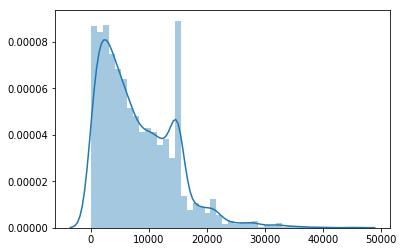

In [7]:
#hhonly_2016.loc[hhonly_2016.NYCgov_PovGap > 0, ['NYCgov_PovGap']].plot()
sns.distplot(hhonly_2016.loc[hhonly_2016.NYCgov_PovGap > 0, ['NYCgov_PovGap']])

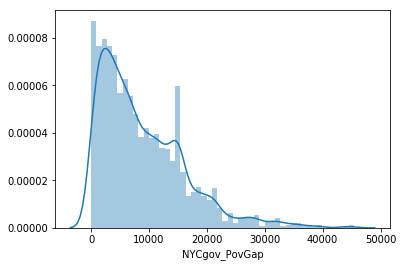

In [11]:
sns.distplot(df.loc[(df.Year == 2016) & (df.NYCgov_PovGap > 0), 'NYCgov_PovGap'])

In [ ]:
# cols = df.loc[(df.Year == 2016) & (df.AGEP > 25), raw_inp_vars].corr()
sns.heatmap(cols,  xticklabels=cols.columns.values, yticklabels=cols.columns.values)
pd.DataFrame(cols.PreTaxIncome_PU.reindex(cols.PreTaxIncome_PU.abs().sort_values(ascending=False).index)).tail(-1)

## Correlating Variables in 2016

Note first of all that there are two key correlations we're looking for here -- correlations with poverty *status* and correlations with poverty *rate*.  Since the poverty rate is determined by averaging the poverty status in a given group, these correlations will track closely, but I'll attempt to distinguish which I'm discussing as we go.

The heatmap of correlations looks pretty, but it's hard to get any value out of it; so instead I'm going to pull out the variables that are the most strongly correlated with poverty status (sorted by absolute value of correlation -- here I'm more interested in the *strength* of the correlation than the *direction* of the correlation). 

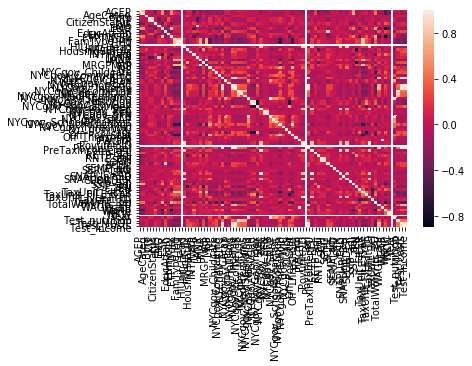

In [53]:
corr_2016 = hhonly_2016.corr()
sns.heatmap(corr_2016,  xticklabels=corr_2016.columns.values, yticklabels=corr_2016.columns.values)

The key variables that correlate with poverty status are work-related and income-related. (The Tax_Unit variables are noise for this analysis.) In the
second half of the list we see ESR (employment status), educational attainment, and a number of 'NYC' variables showing
income tax, costs for commuting, and medical costs.

Interestingly, some key variables such as age, number of people in the household, and type of household don't show up here.
These key variables are not strongly *linearly* correlated with poverty status across the entire data set; but below we'll investigate those further.

In [59]:
# Input variables with strongest correlation with poverty
inp_2016 = hhonly_2016[['NYCgov_Pov_Stat'] + raw_inp_vars + acs_vars + nyc_vars] # focus only on input variables
inp_corr_2016 = inp_2016.corr() # get correlation
# Sort by absolute-value of correlation
pd.DataFrame(inp_corr_2016.NYCgov_Pov_Stat.reindex(inp_corr_2016.NYCgov_Pov_Stat.abs().sort_values(ascending=False).index)).tail(-1).head(10)

,NYCgov_Pov_Stat
TaxUnit_FILETYPE,-0.513799
TotalWorkHrs_PU,-0.386101
NYCgov_Income,0.377111
PreTaxIncome_PU,0.321488
FTPTWork,-0.317600
TaxUnit_FILER,0.304692
NYCgov_FICAtax,0.297104
WKHP,0.296817
WAGP_adj,0.259148
ESR,-0.258451


## Age and Poverty Status in 2016

As mentioned above, age shows a weak linear correlation across the entire dataset; however, by splitting the age groups into 18-30 years of age, and 30+ years of age, poverty rates become more strongly correlated to age than to any other variable. 

Correlation for 18-29 years old: -0.913
Linear regression for 18-29 years old: -6.56 * x + 197.26
Correlation for 30+ years old: 0.763
Linear regression for 30+ years old: 0.19 * x + 10.79


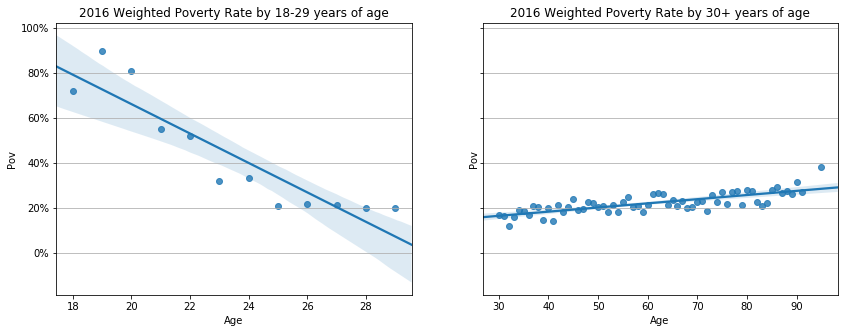

In [48]:
# Set up variables
n = 0
column = raw_inp_vars[n]
year = 2016
pcts = df_for_pov_chart_nocats(hhonly_2016, raw_inp_vars[n], 'PWGTP')
pcts_18_29 = pcts[3:15]
pcts_30plus = pcts[15:]
pcts_18_29.reset_index(inplace=True)
pcts_30plus.reset_index(inplace=True)
m_young, b_young = np.polyfit(pcts_18_29.AGEP, pcts_18_29.Pov, 1)
m_old, b_old = np.polyfit(pcts_30plus.AGEP, pcts_30plus.Pov, 1)


# Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)
for year in range(2):
    # initialize variables
    pcts = [pcts_18_29, pcts_30plus][year] 
    group = ['18-29 years', '30+ years']
    m, b = [(m_young, b_young), (m_old, b_old)][year]
    
    # Create regressions
    m, b = np.polyfit(pcts.AGEP, pcts.Pov, 1)
    
    ax = sns.regplot(data=pcts, x=column, y='Pov', ax=axes[year], color=sns.color_palette()[0])#, ci=None)
    ax.set_xlabel('Age')
    ax.set_title('2016 Weighted Poverty Rate by ' + group[year] + ' of age')
    print('Correlation for ' + str(group[year]) + ' old: ' + '{:4.3f}'.format(pcts.corr().iloc[0,1]))
    ax.grid(which='major', axis='y')
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
    print('Linear regression for ' + str(group[year]) + ' old: ' + '{:4.2f}'.format(m) + ' * x + ' + '{:4.2f}'.format(b))

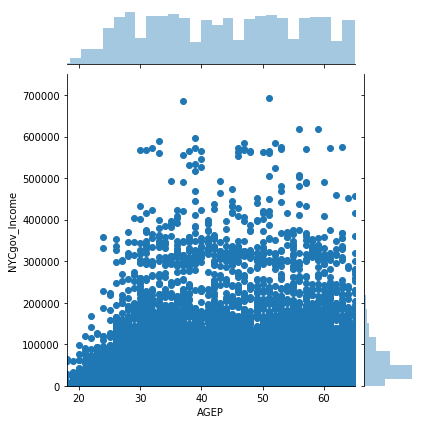

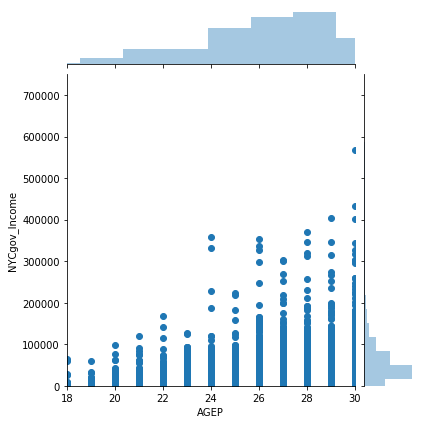

In [68]:
sns.jointplot(hhonly_2016.AGEP, hhonly_2016.NYCgov_Income, xlim=[18,65], ylim=[0, 750000])
sns.jointplot(hhonly_2016.AGEP, hhonly_2016.NYCgov_Income, xlim=[18,30], ylim=[0, 750000])

Age 18-29:
                     AGEP  PreTaxIncome_PU
AGEP             1.000000         0.284161
PreTaxIncome_PU  0.284161         1.000000

Age 30+:
                    AGEP  PreTaxIncome_PU
AGEP             1.00000         -0.12621
PreTaxIncome_PU -0.12621          1.00000


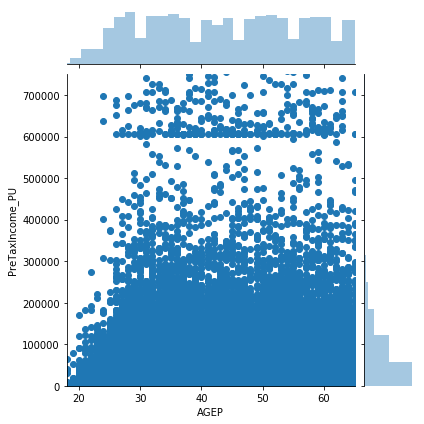

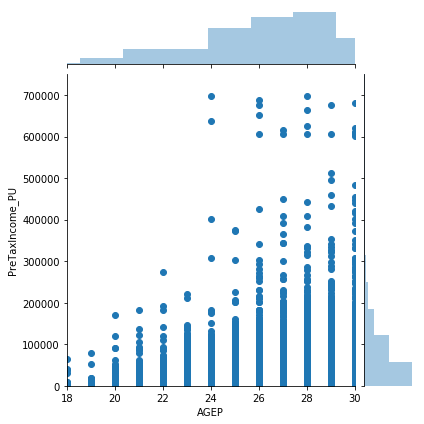

In [86]:
sns.jointplot(hhonly_2016.AGEP, hhonly_2016.PreTaxIncome_PU, xlim=[18,65], ylim=[0, 750000])
sns.jointplot(hhonly_2016.AGEP, hhonly_2016.PreTaxIncome_PU, xlim=[18,30], ylim=[0, 750000])
#PreTaxIncome_PU 
print('Age 18-29:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 18) & (hhonly_2016.AGEP < 30), ['AGEP', 'PreTaxIncome_PU']].corr()))
print()
print('Age 30+:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 30), ['AGEP', 'PreTaxIncome_PU']].corr()))

WAGP_adj    28826.119248
dtype: float64

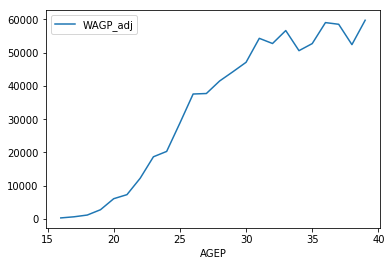

In [71]:
young = df[(df.Year == 2016) & (df.AGEP >= 18) & (df.AGEP <= 30) & (df.WAGP_adj <= 100000)]
#sns.scatterplot(young.AGEP, young.WAGP_adj)
#sns.regplot(young.AGEP, young.WAGP_adj)
#sns.jointplot(young.AGEP, young.WAGP_adj)

df.loc[(df.Year == 2016), ['AGEP', 'WAGP_adj']].groupby('AGEP').mean()[16:40].plot() #6071.
df.loc[(df.Year == 2016) & (df.AGEP == 20), ['WAGP_adj']].mean() #6071.
df.loc[(df.Year == 2016) & (df.AGEP == 25), ['WAGP_adj']].mean() #28826

#sns.jointplot(df[df.Year == 2016].AGEP, df[df.Year == 2016].WAGP_adj, xlim=[18,30], ylim=[0, 10000])
#sns.jointplot(hhonly_2016.AGEP, hhonly_2016.PreTaxIncome_PU, xlim=[18,30], ylim=[0, 750000])
#PreTaxIncome_PU 
#print('Age 18-29:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 18) & (hhonly_2016.AGEP < 30), ['AGEP', 'PreTaxIncome_PU']].corr()))
#print()
#print('Age 30+:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 30), ['AGEP', 'PreTaxIncome_PU']].corr()))

WKHP    34.71258
dtype: float64

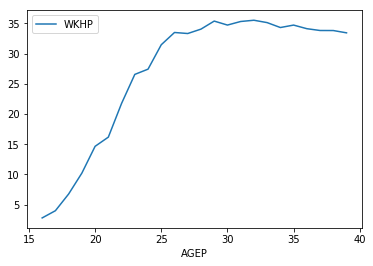

In [82]:
df.loc[(df.Year == 2016), ['AGEP', 'WKHP']].groupby('AGEP').mean()[16:40].plot() #6071.
df.loc[(df.Year == 2016) & (df.AGEP == 20), ['WKHP']].mean() #14.6
df.loc[(df.Year == 2016) & (df.AGEP == 25), ['WKHP']].mean() #31.5
df.loc[(df.Year == 2016) & (df.AGEP == 35), ['WKHP']].mean() #34.7

Age 18-29:
                      AGEP  NYCgov_Threshold
AGEP              1.000000          0.154504
NYCgov_Threshold  0.154504          1.000000

Age 30+:
                      AGEP  NYCgov_Threshold
AGEP              1.000000         -0.164462
NYCgov_Threshold -0.164462          1.000000


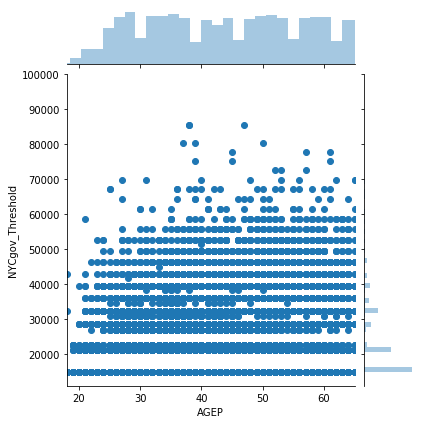

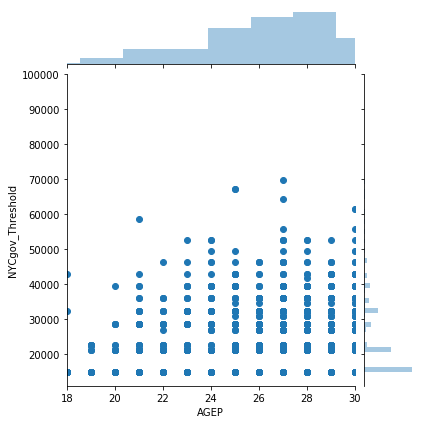

In [84]:
sns.jointplot(hhonly_2016.AGEP, hhonly_2016.NYCgov_Threshold, xlim=[18,65], ylim=[11000, 100000])
sns.jointplot(hhonly_2016.AGEP, hhonly_2016.NYCgov_Threshold, xlim=[18,30], ylim=[11000, 100000])
print('Age 18-29:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 18) & (hhonly_2016.AGEP < 30), ['AGEP', 'NYCgov_Threshold']].corr()))
print()
print('Age 30+:\n' + str(hhonly_2016.loc[(hhonly_2016.AGEP >= 30), ['AGEP', 'NYCgov_Threshold']].corr()))
#hhonly_2016[['AGEP', 'NYCgov_Threshold']].corr()

In [76]:
df.NYCgov_Threshold.max()

95675.0091657571

In [6]:
weighted_pers = df[personal_vars].copy()
sum_personal_weights = sum(weighted_pers.PWGTP)
weighted_pers = weighted_pers.multiply(weighted_pers.PWGTP, axis=0)
#Pweighted = Pweighted / tot_weights
#print(tot_weights)
weighted_pers.head()

,AGEP,Boro,CIT,SCH,SCHG,SCHL,SEX,ESR,ENG,LANX,...,SNAPUnit_Rel,TaxUnit_FILER,TaxUnit_FILESTAT,TaxUnit_FILETYPE,Ethnicity,EducAttain,CitizenStatus,AgeCateg,PWGTP,FTPTWork
0,51471.0,1634.0,3268.0,817.0,0.0,8170.0,817.0,4902.0,4085.0,1634.0,...,817.0,0.0,3268.0,2451.0,1634.0,2451.0,1634.0,1634.0,667489.0,2451.0
1,7410.0,190.0,95.0,95.0,0.0,475.0,95.0,570.0,475.0,190.0,...,95.0,0.0,380.0,285.0,190.0,95.0,95.0,285.0,9025.0,285.0
2,7020.0,180.0,90.0,90.0,0.0,630.0,180.0,540.0,450.0,180.0,...,90.0,0.0,360.0,270.0,180.0,90.0,90.0,270.0,8100.0,270.0
3,3276.0,168.0,84.0,84.0,0.0,504.0,168.0,504.0,420.0,168.0,...,84.0,0.0,336.0,252.0,168.0,84.0,84.0,168.0,7056.0,252.0
4,6820.0,620.0,155.0,155.0,0.0,1395.0,310.0,155.0,775.0,310.0,...,155.0,155.0,310.0,155.0,310.0,310.0,155.0,310.0,24025.0,155.0


In [7]:
unweighted_mean_age = np.mean(df.AGEP)
weighted_mean_age = np.sum(weighted_pers.AGEP)/sum_personal_weights
print('Unweighted: ' + str(unweighted_mean_age))
print('Weighted: ' + str(weighted_mean_age))

Unweighted: 38.55422645378794
Weighted: 36.90360934046599


In [9]:
unweighted_non_citizens = df[df.CIT == 5]
weighted_non_citizens = weighted_pers[df.CIT == 5]
unweighted_non_citizen_pct = len(unweighted_non_citizens)/len(df)
weighted_non_citizen_pct = sum(unweighted_non_citizens['PWGTP'])/sum(df['PWGTP'])
print('Unweighted: ' + str(unweighted_non_citizen_pct))
print('Weighted: ' + str(weighted_non_citizen_pct))

Unweighted: 0.15632110448485223
Weighted: 0.17666703532544373


In [35]:
#counts = df['AGEP', 'NYCgov_I', 'PWGTP'].groupby('AGEP')
#print(household_vars)

#df.loc[(df.Year == 2016) & (df.Povunit_Rel == 1), household_vars].corr().NYCgov_Income

df.loc[(df.Year == 2016)].groupby('SERIALNO').sum().corr().NYCgov_Income.sort_values()


NYCgov_PovGapIndex       -0.145125
NYCgov_PovGap            -0.096231
SSP_adj                   0.003663
PA_adj                    0.015368
FamType_PU                0.020355
SSIP_adj                  0.021121
OI_adj                    0.021923
NYCgov_SchoolBreakfast    0.044893
RETP_adj                  0.058535
HHT                       0.067917
TaxUnit_FILESTAT          0.084127
TotalWorkHrs_PU           0.089503
RNTP_adj                  0.093071
NYCgov_WIC                0.095122
TaxUnit_FILETYPE          0.108292
NYCgov_EITC               0.117699
NYCgov_SchoolLunch        0.149310
NYCgov_HEAP               0.155372
INTP_adj                  0.199538
NYCgov_Childcare          0.206525
NYCgov_Nutrition          0.222025
NYCgov_SNAP               0.223824
ESR                       0.228993
MSP                       0.249658
NYCgov_Housing            0.272472
NYCgov_SFR                0.272753
SNAPUnit_ID               0.274032
WGTP                      0.287264
PWGTP               

In [21]:
asd = df.loc[df.Year == 2016]
df.loc[(df.Year == 2016), ['AGEP', 'WAGP_adj', 'WGTP']].groupby('AGEP').sum()

#print(asd[['WAGP_adj', 'WGTP']].head())
#asd.WAGP_adj.mul(asd.WGTP).groupby()
counts = asd.WAGP_adj.mul(asd.WGTP).groupby(asd.AGEP).sum()
total = asd.WGTP.groupby(asd.AGEP).sum()
pcts = counts/total
#print(asd.WAGP_adj.sum())
comp = asd.WAGP_adj.groupby(asd.AGEP).mean().sum()
print(comp)
print(pcts.sum())
print((comp - pcts.sum())/pcts.sum())
#pcts[18:65]
asd.WAGP_adj.groupby(asd.AGEP).mean()[18:65]
#df.loc[(df.Year == 2016), ['AGEP', 'WAGP_adj', 'WGTP']].multiply('WAGP_adj', 'WGTP').groupby('AGEP').sum()

#counts = df.loc[(df.Year == 2016), ['AGEP', 'WAGP_adj', 'WGTP']].groupby('AGEP').multiply('WAGP_adj', 'WGTP').sum()
#div = df.loc[(df.Year == 2016), ['AGEP', 'WAGP_adj', 'WGTP']].groupby('AGEP').sum('WGTP')
#pcts = counts/div
#print(pcts)

2208300.412148636
2215101.6037743287
-0.003070374566161786


AGEP
18     1150.241248
19     2752.504415
20     6071.400348
21     7288.258620
22    12229.799976
23    18686.029169
24    20297.978377
25    28826.119248
26    37574.022884
27    37722.670381
28    41486.394011
29    44259.127899
30    47116.567207
31    54332.468864
32    52773.279961
33    56670.395183
34    50618.093776
35    52749.239574
36    59067.241389
37    58561.244054
38    52435.497934
39    59775.044633
40    56200.934958
41    57667.796636
42    58050.806543
43    54086.258604
44    54805.848151
45    53371.495999
46    55691.839031
47    55775.777043
48    46007.234853
49    50667.347561
50    50390.081871
51    48817.547928
52    50106.954214
53    48622.469017
54    45128.142862
55    46536.407251
56    45725.083664
57    43487.125789
58    43692.467602
59    42760.397105
60    43172.567530
61    38724.487525
62    34922.575193
63    30154.715819
64    27419.455381
Name: WAGP_adj, dtype: float64

In [156]:
df[personal_vars].sum()

AGEP                3.004234e+07
Boro                2.165707e+06
CIT                 1.802626e+06
SCH                 1.004865e+06
SCHG                1.682406e+06
SCHL                1.057389e+07
SEX                 1.196441e+06
ESR                 1.895813e+06
ENG                 2.565264e+06
LANX                1.122746e+06
MSP                 2.247070e+06
MAR                 2.542471e+06
NYCgov_EITC         1.396032e+08
WKW                 7.381720e+05
WKHP                1.550254e+07
DIS                 1.443146e+06
JWTR                1.345498e+06
WAGP_adj            1.961002e+10
INTP_adj            1.348256e+09
SEMP_adj            1.267156e+09
SSP_adj             1.332795e+09
SSIP_adj            1.946823e+08
PA_adj              4.585936e+07
RETP_adj            1.059195e+09
OI_adj              3.536895e+08
TaxUnit_Rel         1.570601e+06
NYCgov_REL          1.388755e+06
NYCgov_SFR          1.387400e+05
SNAPUnit_Rel        1.326956e+06
TaxUnit_FILER       3.738390e+05
TaxUnit_FI

In [165]:
df.PWGTP.describe() # min 10, 25%ile 71, median 99, 75%ile 157, max 2112, mean 125, std 85
df.WGTP.describe() # min 9, 25%ile 69, median 94, 75%ile 148, max 2085, mean 117, std 77
len(df) # 779,223

779223

Limited: 1.4360059818223236,-5990.4388165975615
Total: 1.866823743489061,-23495.012607169043
29595
22419
0.9078168746950269


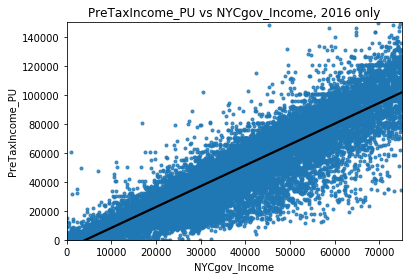

In [57]:
inc_limit = 75000
pt_limit = 150000
limited = hhonly_2016[(hhonly_2016.NYCgov_Income <= inc_limit) & (hhonly_2016.PreTaxIncome_PU <= pt_limit)]
_ = sns.regplot(data=limited, x='NYCgov_Income', y='PreTaxIncome_PU', marker='.', line_kws={'color': 'black'})
#_ = sns.regplot(data=hhonly_2016, x='NYCgov_Income', y='PreTaxIncome_PU', marker='.', line_kws={'color': 'black'})
#_ = plt.xlim([0,750000])
#_ = plt.ylim([0,1500000])
_ = plt.xlim([0,75000])
_ = plt.ylim([0,150000])
_ = plt.title('PreTaxIncome_PU vs NYCgov_Income, 2016 only')

#limited = hhonly_2016[(hhonly_2016.NYCgov_Income <= inc_limit) & (hhonly_2016.PreTaxIncome_PU <= pt_limit)]
m_lim, b_lim = np.polyfit(limited.NYCgov_Income, limited.PreTaxIncome_PU, 1)
                          #hhonly_2016.loc[hhonly_2016.PreTaxIncome_PU <= pt_limit, 'PreTaxIncome_PU'], 1)
m, b = np.polyfit(hhonly_2016.NYCgov_Income, hhonly_2016.PreTaxIncome_PU, 1)
print('Limited: ' + str(m_lim) + ',' + str(b_lim))
print('Total: ' + str(m) + ',' + str(b))
print(len(hhonly_2016))
print(len(limited))
print(limited[['NYCgov_Income', 'PreTaxIncome_PU']].corr().iloc[0,1])
#_ = plt.annotate('Regression:\n' + '{:4.2f}'.format(m) + ' * x + ' + '{:4.2f}'.format(b), xy=(400000, 400000 * m + b), 
                 #xytext=(430000, 400000 * m + b - 200000), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))

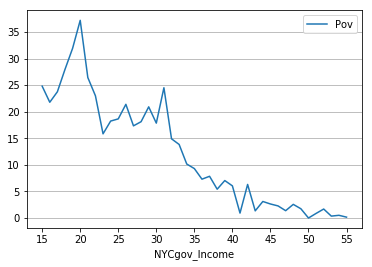

In [358]:
pov_2016 = hhonly_2016.loc[hhonly_2016['NYCgov_Pov_Stat'] == 1]
not_pov_2016 = hhonly_2016.loc[hhonly_2016['NYCgov_Pov_Stat'] == 2]
pov_dist_2016 = sorted(pov_2016.NYCgov_Income)
not_pov_dist_2016 = sorted(not_pov_2016.NYCgov_Income)
#_ = plt.plot(ecdf(pov_dist_2016), marker='.', linestyle='none')
#_ = plt.plot(ecdf(not_pov_dist_2016), marker='.', linestyle='none')
#len(not_pov_2016)
#ecdf(not_pov_dist_2016).index

# Create the charts
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)
                    #for year, axis in zip(years, range(3)):
                    #pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
                    #ax = pcts.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
                    #ax.grid(which='major', axis='y')
                    #plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
#plt.subplot(121)
#ecdf_plot(pov_dist_2016)
#plt.subplot(122)
#ecdf_plot(not_pov_dist_2016)

grouped = hhonly_2016[['NYCgov_Pov_Stat', 'WGTP', 'NYCgov_Income']].groupby([hhonly_2016.NYCgov_Income//1000, 'NYCgov_Pov_Stat']).sum()
counts = grouped.sum(level=0)
pcts = grouped.WGTP/counts.WGTP
pcts = pcts.unstack('NYCgov_Pov_Stat')
counts.tail(-30).head(15) # 18: 43366+16840
#counts.columns
grouped.tail(-30).head(15)
pcts.tail(-30).head(15)

#subtotals = counts.sum(level=0)
    #pcts = 100 * counts / subtotals

thousands = hhonly_2016[['NYCgov_Income', 'NYCgov_Pov_Stat', 'WGTP', 'Povunit_Rel', 'Year']].copy()
thousands['Povunit_Rel'] = 'Head'
thousands['NYCgov_Income'] = thousands.NYCgov_Income // 1000
thousands['NYCgov_Pov_Stat'] = np.where(thousands.NYCgov_Pov_Stat.eq(1), 'Pov', 'Not Pov')
#df_for_pov_chart(thousands, 'NYCgov_Income', 'WGTP').loc[:80].fillna(0).plot()
ax = df_for_pov_chart(thousands, 'NYCgov_Income', 'WGTP').loc[15:55].fillna(0).plot()
#thousands.NYCgov_Income
#??df_for_pov_chart
#bar_sub(thousands, 'NYCgov_Income', [2016])
#??bar_sub
ax.grid(which='major', axis='y')


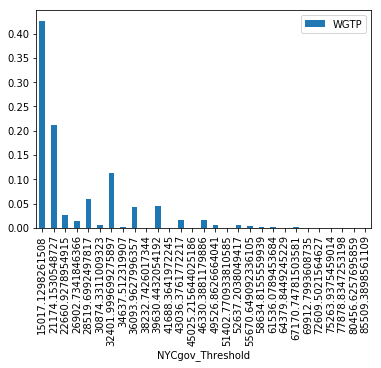

In [377]:
povgap = hhonly_2016[['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'WGTP', 'Povunit_Rel', 'Year']].copy()
povgap['Povunit_Rel'] = 'Head'

#ax = df_for_stat_chart(povgap, 'NYCgov_PovGap', 'WGTP').plot()#oc[15:55].fillna(0).plot()
#ax.grid(which='major', axis='y')
#df_for_stat_chart(povgap, 'NYCgov_PovGap', 'WGTP')#.plot()#oc[15:55].fillna(0).plot()



thresh = hhonly_2016[['NYCgov_Threshold', 'NYCgov_Pov_Stat', 'WGTP', 'Povunit_Rel', 'Year']].copy()
thresh['Povunit_Rel'] = 'Head'

ax = df_for_stat_chart(thresh, 'NYCgov_Threshold', 'WGTP').plot(kind='bar')#oc[15:55].fillna(0).plot()

In [ ]:
#n = 10
#column = 'NYCgov_Income'
column = 'PreTaxIncome_PU'
weights_column = 'WGTP'
dataframe = hhonly_2016
#scatter_sub(cats, 'NYCgov_Income')
#df_for_pov_chart(hhonly_2016, 'NYCgov_Income', 'PWGTP')
#df_for_pov_chart(cats.loc[(cats.Year == 2016) & (cats.Povunit_Rel == 'Head')], 'PreTaxIncome_PU', 'PWGTP')

#If the weight is by household, need to filter by household head
if weights_column == 'WGTP':
    counts = dataframe.loc[dataframe['Povunit_Rel'] == 1, ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
else:
    counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
# count and create % poverty by column    
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
    
# only return the % in poverty by column
#return pd.DataFrame(pcts[weights_column]['Pov'])
pcts

#scatter_sub_stat(cats, 'NYCgov_Income')

## Poverty Rate by Year

* The overall poverty rate was 19.5% in 2016.
    * From 20.3% in 2005, it increased to 20.6% in 2010 (after the recession), and decreased to 19.5% in 2016.
* The yearly decreases look small, but are important.
    * 0.1% decrease in poverty in NYC is about 8,500 people.

In [ ]:
column = 'NYCgov_Pov_Stat'
weight = 'PWGTP'

counts = cats[['Year', column, weight]].groupby(['Year', column]).sum()
denoms = counts.groupby('Year').sum()
#pcts = counts / np.sum(counts)
pcts = 100 * counts / denoms
pcts = pcts.unstack('NYCgov_Pov_Stat')['PWGTP']

diffs = pcts['Pov'][1:] - pcts['Pov'][:-1]
pcts

In [ ]:
column = 'NYCgov_Pov_Stat'
weight = 'PWGTP'

# Create the charts
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
for year, axis in zip([2005, 2010, 2016], range(3)):
    
    # count and create % by column    
    counts = df.loc[df.Year == year, [column, weight]].groupby(column).sum()
    pcts = 100 * counts / np.sum(counts)
    
    # chart by year
    ax = pcts.plot(kind='bar', title = 'NYC Poverty ' + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
    ax.grid(which='major', axis='y')
    plt.gca().set_xticklabels(['Pov', 'Not Pov'])
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 

## Age and Poverty Status

* Age has one of the largest impacts on poverty status.  
    * Note the cluster below age 25.
    * Above age 25 there appears to be a strong correlation with poverty rate.  
    * If you're in an age group with more than 22% poverty, you're either younger than 25 or over 60.

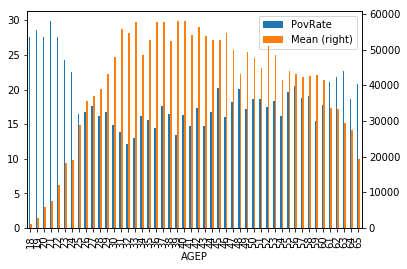

In [24]:
# Put these back in later!
money = cats
money = money.assign(WWAGP = money.WAGP_adj * money.PWGTP)

n = 0
column = raw_inp_vars[n]
weight = 'PWGTP' if column in per_vars else 'WGTP'
df_for_pov_chart(cats, raw_inp_vars[n], weight)
#cats.loc[(cats['AGEP'] >= 18) & (cats['AGEP'] < 65) & (cats['Year'] == 2016),['AGEP', 'WAGP_adj']].groupby('AGEP').describe()
#cats.loc[(cats['AGEP'] >= 18) & (cats['AGEP'] < 65) & (cats['Year'] == 2016),['AGEP', 'WAGP_adj' * 'PWGTP']].groupby('AGEP').describe()

ages_both = money.loc[(money['Year'] == 2016),['AGEP', 'WWAGP', 'PWGTP']].groupby('AGEP').sum()
ages_both['Mean'] = ages_both['WWAGP'] / ages_both['PWGTP']
ages_both['PovRate'] = df_for_pov_chart(cats.loc[cats['Year'] == 2016], raw_inp_vars[n], weight)

#ages_both.loc[(ages_both['AGEP'] >= 18) & (ages_both['AGEP'] < 65), ['PovRate', 'Mean']]
ages_both.loc[18:65, ['PovRate', 'Mean']].plot(kind='bar', secondary_y='Mean')
#ages_both.loc[65:, ['PovRate', 'Mean']].plot(kind='bar', secondary_y='Mean')



#np.average(sales["Current_Price"], weights=sales["Quantity"])
#sales.groupby("Manager").apply(lambda x: np.average(x['New_Product_Price'], weights=x['Quantity']))

#money.loc[(money['AGEP'] >= 18) & (money['AGEP'] < 65)].groupby('AGEP').apply(lambda c: np.average(c['WAGP_adj'], weights=c['PWGTP']))

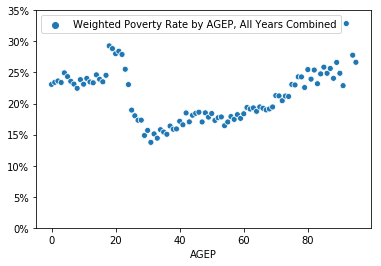

In [54]:
n = 0
scatter_combined(cats, raw_inp_vars[n])

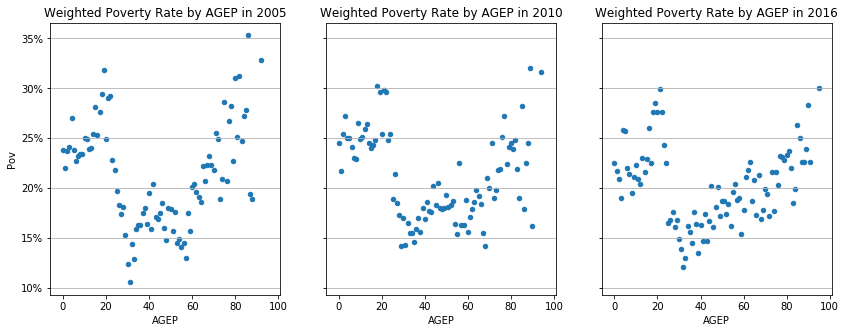

In [44]:
n = 0
scatter_sub(cats, raw_inp_vars[n])

* The distribution of population by age is also somewhat surprising:
    * Similar clustering between age < 25 and 25+ as in the poverty chart above.
    * 2005 and 2016 look very similar; the population is not significantly aging.
    * Birth rates and/or in-migration are keeping the population by age group relatively stable.
    * This is not the case in lots of other areas around the US.
* We'll dig into this further in EDA.

In [ ]:
n = 0
scatter_sub_stat(cats, raw_inp_vars[n], ylimits=[0, 0.025])

In [27]:
n = 0
column=raw_inp_vars[n]
weight = 'PWGTP'
pop_by_age_2005 = df_for_stat_chart(cats[cats.Year == 2005], raw_inp_vars[n], weight)
pop_by_age_2016 = df_for_stat_chart(cats[cats.Year == 2016], raw_inp_vars[n], weight)

dester05 = pop_by_age_2005.reset_index()
dester05 = dester05.groupby(dester05.AGEP.apply(lambda x: int(x) //10)).sum()
#dester05 = dester05*10000000
unweighted05 = df.loc[df.Year == 2005, 'AGEP']
unweighted16 = df.loc[df.Year == 2016, 'AGEP']

dester16 = pop_by_age_2016.reset_index()
#dester16 = dester16.groupby(dester16.AGEP.apply(lambda x: int(x) //10)).sum()
#dester16 = dester16*10000000 # statistict = 193,746+ pvalue=0.0

#chisquare(dester16.PWGTP, dester05.PWGTP)
unweighted05.value_counts().sort_index().sum() # 60,507
cinq = pd.DataFrame(unweighted05.value_counts().sort_index()[:88])
cinq = cinq.groupby(cinq.AGEP.apply(lambda x: int(x) //10)).sum()
unweighted16.value_counts().sort_index().sum() # 68,619
(unweighted16.value_counts().sort_index()*(60507/68619)).sum()
seize = pd.DataFrame((unweighted16.value_counts().sort_index()*(60507/68619))[:88])
seize = seize.groupby(seize.AGEP.apply(lambda x: int(x) //10)).sum()
dester16 = dester16.groupby(dester16.AGEP.apply(lambda x: int(x) //10)).sum()
#seize
#cinq
#cinq-seize
#chisquare(seize, cinq)
#dester05.PWGTP

#def categories(series):
    #return range(int(series.min()), int(series.max()) + 1)


#def chi_square_of_df_cols(df, col1, col2):
    #df_col1, df_col2 = df[col1], df[col2]

    #result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               #for cat2 in categories(df_col2)]
              #for cat1 in categories(df_col1)]

    #return scs.chi2_contingency(result)


#test_df = pd.read_csv('test_data_for_chi_square.csv')
#print(chi_square_of_df_cols(test_df, 'var1', 'var2'))

#b2 = cats.loc[cats.Year == 2005, [raw_inp_vars[n], weight]]
#b2.groupby(b2.AGEP //10).sum()
#chisquare(dester16.AGEP, dester05.AGEP)
#dester16-dester05
#dester05
#dester16

In [ ]:
n = 0
weight = 'PWGTP'
pop_by_age_2005 = df_for_stat_chart(cats[cats.Year == 2005], raw_inp_vars[n], weight)
pop_by_age_2016 = df_for_stat_chart(cats[cats.Year == 2016], raw_inp_vars[n], weight)

#cats.loc[cats.Year == 2005, [raw_inp_vars[n], weight]]
#cats.loc[cats.Year == 2005, raw_inp_vars[n] * weight]
#cats[raw_inp_vars[n] * weight]

bins = np.linspace(cats.AGEP.min(), cats.AGEP.max(), 10)
groups = cats.groupby(np.digitize(cats.AGEP, bins))
groups.PWGTP.sum()
#bins


#diff[diff.PWGTP.isna()] #89, 90, 91, 92, and 95
#pop_by_age_2005.iloc[89]
#pop_by_age_2005.reset_index()
#pop_by_age_2005.iloc[90] = [89, 0]
#pop_by_age_2005
#new_tester=pd.DataFrame(index=['AGEP'], columns=['PWGTP'])
#fix_2005=pd.DataFrame(columns=['PWGTP'])
#fix_2005.loc[89] = 0
#fix_2005.loc[90] = 0
#fix_2005.loc[91] = 0
#fix_2005.loc[95] = 0
#pop_by_age_2005 = pop_by_age_2005.append(fix_2005)
#pop_by_age_2005.sort_index()
#pop_by_age_2016.iloc[85:]
#fix_2016=pd.DataFrame(columns=['PWGTP'])
#fix_2016.loc[92] = 0
#pop_by_age_2016 = pop_by_age_2016.append(fix_2016)
#diff[diff.PWGTP.isna()] #89, 90, 91, 92, and 95
#pop_by_age_2005.iloc[85:]
#diff = pop_by_age_2016 - pop_by_age_2005
#diff[diff.PWGTP.isna()] #89, 90, 91, 92, and 95
#chisquare(pop_by_age_2016, pop_by_age_2005)
#pop_by_age_2005[pop_by_age_2005.PWGTP == 0]

## Age Category

* Here's another look by age; the disparity in poverty rates by group seems to have diminished since 2005.

In [ ]:
n = 0
bar_sub(cats, acs_vars[n])

## Borough

* New York City ("NYC") has five boroughs (see https://en.wikipedia.org/wiki/Boroughs_of_New_York_City), for which poverty rates have gone in different directions over time:
    * Poverty rates have decreased fairly dramatically in the Bronx and Brooklyn.
    * They have also decreased in Manhattan.
    * Poverty rates have increased in Queens and especially Staten Island.

In [ ]:
n = 1
bar_sub(cats, raw_inp_vars[n])

* Income varies dramatically by borough, as shown below.
    * I've focused in on the IQRs of the charts because outliers make the charts difficult to interpret.
    * Median pretax income in the Bronx is roughly *half* that of Staten Island. 
    * Median incomes by borough have increased roughly 25-33% over the 11-year period, though unevenly.  
    * Manhattan seems to have the most outliers (not shown on this chart).

In [ ]:
id = 'Boro'
group = raw_codes
target = 'PreTaxIncome_PU'
cols = 3
rows = len(group[id])
weight = 'PWGTP' if id in per_vars else 'WGTP'

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(15)

for row in group[id]:
    for year, col_axis in zip([2005, 2010, 2016], range(cols)):
        foc_df = cats.loc[(cats[id] == group[id][row]) & (cats['Year'] == year), target]
        
        chart_title = title = str(target) + ' by ' + str(group[id][row]) + ' in ' + str(year)
        ax = foc_df.plot(kind='box', title = chart_title, ax=axes[row - 1, col_axis], ylim=(0,200000))
        ax.grid(which='major', axis='y')

plt.tight_layout()

* Population shares by borough have remained fairly consistent over time.
* Brooklyn and the Bronx (the two boroughs with the highest poverty) represent roughly half of NYC.

In [ ]:
n = 1
bar_sub_stat(cats, raw_inp_vars[n])

## Total Work Hours by Poverty Unit ('TotalWorkHrs_PU')

* Households with at least the equivalent of one half-time worker have dramatically better poverty rates.

In [ ]:
n = 30
bar_sub(cats, nyc_vars[n])

In [ ]:
n = 30
column = nyc_vars[n]
weight = 'WGTP'


# If the weight is by household, need to filter by household head
#if weight == 'WGTP':
#    counts = df.loc[df['Povunit_Rel'] == 1, ['NYCgov_Pov_Stat', column, weight]].groupby([column, 'NYCgov_Pov_Stat']).sum()
#else:
#    counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
#        
# count and create % poverty by column    
#subtotals = counts.sum(level=0)
#pcts = 100 * counts / subtotals
#pcts = pcts.unstack('NYCgov_Pov_Stat')
#    
# only return the % in poverty by column
#pcts = pd.DataFrame(pcts[weight]['Pov'])
#pcts = pcts.rename(columns={1: 'Pov', 2: 'No Pov'})
#pcts







pcts = df_for_pov_chart_nocats(df.loc[df.Year == 2016], column, weight).reset_index().dropna()
m, b = np.polyfit(pcts.TotalWorkHrs_PU, pcts.Pov, 1)
#xs = np.linspace(0, 100)
#ys = m * xs + b

# Plot chart, label, and annotate
#_ = plt.plot(pcts.WKHP, pcts.Pov, marker='.', linestyle='none')
#_ = sns.regplot(pcts.WKHP, pcts.Pov, marker='.')#, linestyle='none')
_ = sns.regplot(data=pcts, x='TotalWorkHrs_PU', y='Pov', marker='.')#, linestyle='none')
_ = plt.xlabel('Total annual hours worked by poverty unit members (Household)')
_ = plt.ylabel('Poverty Rate')
_ = plt.title('Total Household Hours Worked vs. Poverty Rate, 2016')
#_ = plt.annotate('0 Hours:\n' + '{:4.1f}%'.format(0 * m + b), xy=(0, 0 * m + b), xytext=(5, 0 * m + b + 5), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))
#_ = plt.annotate('20 Hours:\n' + '{:4.1f}%'.format(20 * m + b), xy=(20, 20 * m + b), xytext=(25, 20 * m + b + 5), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))
#_ = plt.annotate('40 Hours:\n' + '{:4.1f}%'.format(40 * m + b), xy=(40, 40 * m + b), xytext=(45, 40 * m + b + 5), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))
#_ = plt.annotate('60 Hours:\n' + '{:4.1f}%'.format(60 * m + b), xy=(60, 60 * m + b), xytext=(65, 60 * m + b + 5), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))
#_ = plt.annotate('80 Hours:\n' + '{:4.1f}%'.format(80 * m + b), xy=(80, 80 * m + b), xytext=(85, 80 * m + b + 5), 
                 #arrowprops=dict(facecolor='black', shrink=0.05))
#_ = plt.plot(xs, ys)
print('Correlation between TotalWorkHrs_PU and Poverty Rate: ' + '{:4.2f}'.format(np.corrcoef(pcts.TotalWorkHrs_PU, pcts.Pov)[0,1]))

* About 35% of households don't have at least the equivalent of one half-time worker, a figure that's remained relatively stable through the years.

In [ ]:
n = 30
bar_sub_stat(cats, nyc_vars[n])

## Usual Hours Worked ('WKHP')

* This statistic is *individual* hours worked; while there appears to be less poverty among those who work more, there are lots of outliers. Will need to dig deeper on income versus work hours.

In [ ]:
n = 23
scatter_sub(cats, raw_inp_vars[n])

In [ ]:
hhonly_2016.WKHP.nunique()
hhonly_2016.PreTaxIncome_PU.nunique()
hhonly_2016.NYCgov_Income.nunique()

In [ ]:
n = 23
column = raw_inp_vars[n]
weight = 'PWGTP'
pcts = df_for_pov_chart(cats.loc[cats.Year == 2016], column, weight).reset_index().dropna()
m, b = np.polyfit(pcts.WKHP, pcts.Pov, 1)
#xs = np.linspace(0, 100)
#ys = m * xs + b

# Plot chart, label, and annotate
#_ = plt.plot(pcts.WKHP, pcts.Pov, marker='.', linestyle='none')
#_ = sns.regplot(pcts.WKHP, pcts.Pov, marker='.')#, linestyle='none')
_ = sns.regplot(data=pcts, x='WKHP', y='Pov', marker='.')#, linestyle='none')
_ = plt.xlabel('Usual hours worked per week past 12 months (Individual)')
_ = plt.ylabel('Poverty Rate')
_ = plt.title('Usual Hours Worked/Week vs. Poverty Rate, 2016')
_ = plt.annotate('0 Hours:\n' + '{:4.1f}%'.format(0 * m + b), xy=(0, 0 * m + b), xytext=(5, 0 * m + b + 5), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
_ = plt.annotate('20 Hours:\n' + '{:4.1f}%'.format(20 * m + b), xy=(20, 20 * m + b), xytext=(25, 20 * m + b + 5), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
_ = plt.annotate('40 Hours:\n' + '{:4.1f}%'.format(40 * m + b), xy=(40, 40 * m + b), xytext=(45, 40 * m + b + 5), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
_ = plt.annotate('60 Hours:\n' + '{:4.1f}%'.format(60 * m + b), xy=(60, 60 * m + b), xytext=(65, 60 * m + b + 5), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
_ = plt.annotate('80 Hours:\n' + '{:4.1f}%'.format(80 * m + b), xy=(80, 80 * m + b), xytext=(85, 80 * m + b + 5), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
#_ = plt.plot(xs, ys)
print('Correlation between WKHP and Poverty Rate: ' + '{:4.2f}'.format(np.corrcoef(pcts.WKHP, pcts.Pov)[0,1]))

In [ ]:
#sns.lmplot(x="NYCgov_PovGap", y="PreTaxIncome_PU", hue="NYCgov_Pov_Stat", data=hhonly2016)
#sns.jointplot(x="Boro", y="NYCgov_Pov_Stat", data=hhonly2016, kind='hex')
sns.jointplot(x="Boro", y="NYCgov_Pov_Stat", data=hhonly2016, kind='hex')
#sns.pairplot(hhonly2016[['Boro', 'NYCgov_Pov_Stat']])
#cats.columns
#print(hh_vars)
#ct_table = pd.crosstab(hhonly2016['Boro'], hhonly2016['NYCgov_Pov_Stat'])
#ct_table.plot(kind='bar', stacked=True)
#clarity_color_table = pd.crosstab(index=train["clarity"],  columns=train["color"])
#clarity_color_table.plot(kind="bar",  figsize=(8,8), stacked=True)

#from mpl_toolkits.mplot3d import Axes3D
# Transform it in a dataframe
#data=pd.DataFrame({'x': xi.flatten(), 'y': yi.flatten(), 'z': zi })
#data = hhonly2016
 
# Make the plot
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.plot_trisurf(hhonly2016.NYCgov_PovGap, hhonly2016.PreTaxIncome_PU, hhonly2016.WAGP_adj, cmap=plt.cm.Spectral, linewidth=0.2)

## Weeks Worked Past 12 Months ('WKW')

* The chart by weeks worked past 12 months, also an individual stat, is suprising in that it looks almost exactly like you'd expect.

In [ ]:
n = 24
bar_sub(cats, raw_inp_vars[n])

In [ ]:
n = 24
column = raw_inp_vars[n]
weight = 'PWGTP'
pcts = df_for_pov_chart(cats.loc[cats.Year == 2016], column, weight).reset_index().dropna()
pcts['WKW'] = pd.Categorical(pcts['WKW'], ['<13', '14-26', '27-39', '40-47', '48-49', '50-52', 'NA'])

#custom_dict = {'<13':0,'14-26':1,'27-39':3, '40-47':4, '48-49':5, '50-52':6, 'NA':7}
pcts = pcts.sort_values('WKW')
pcts = pcts.set_index('WKW')

# Plot chart, label, and annotate
_ = pcts.plot(kind='bar', legend=None)
for i in range(len(pcts)):
    _ = plt.annotate('{:3.1f}%'.format(pcts.iloc[i]['Pov']), xy=(0, 0), xytext=(i - .3, pcts.iloc[i] + .2), 
                 arrowprops=None)
_ = plt.xlabel('Weeks worked past 12 months (Individual)')
_ = plt.ylabel('Poverty Rate')
_ = plt.title('Weeks Worked Past 12 Months vs. Poverty Rate, 2016')

In [ ]:
sns.jointplot(x='WKW', y='WAGP_adj', data=df.loc[df.Year == 2016])

## Salary/Wages ('WAGP_adj')

* Salary/Wages has a fairly strong correlation with poverty level, but not as much as one might naively expect.
* Note the 'column' around WAGP_adj=0; the relationship appears somewhat linear outside of that, but with lots of noise.

In [ ]:
n = 10
scatter_sub(cats, acs_vars[n])

## Social Security ('SSP_adj')

* Note the 'column' from 0-2500, with no clear relationship between Social Security and poverty rate.
* Interestingly, above roughly 2500 dollars/year, there appears to be somewhat of a correlation.

In [ ]:
n = 9
scatter_sub(cats, acs_vars[n])

## Disability Status

* The poverty rate is much higher among the disabled than the non-disabled in 2010 and 2016.

In [ ]:
n = 3
bar_sub(cats, raw_inp_vars[n])

In [ ]:
n = 3
column = raw_inp_vars[n]
weight = 'PWGTP'
#pcts = df_for_pov_chart(cats.loc[cats.Year == 2016], column, weight).reset_index().dropna()
#pcts['WKW'] = pd.Categorical(pcts['WKW'], ['<13', '14-26', '27-39', '40-47', '48-49', '50-52', 'NA'])

#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=1, ncols=11, sharex=True, sharey=True)
for year, axis in zip(range(2005, 2016), range(11)):
    pcts = df_for_pov_chart(cats.loc[cats.Year == year], column, weight)
    ax = pcts.plot(kind='bar', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
    ax.grid(which='major', axis='y')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

#fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(14,5), sharex=True, sharey=True)
#fig, axes = plt.subplots(nrows=11, ncols=1, sharex=True, sharey=True)
#for year, axis in zip(range(2005, 2016), range(11)):
    #pcts = df_for_stat_chart(cats.loc[cats.Year == year], column, weight)
    #ax = pcts.plot(kind='bar', title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
    #ax.grid(which='major', axis='y')

## Ethnicity

* Asian and Hispanic groups have higher poverty rates, and both groups continue to grow in share of population.

In [ ]:
n = 6
bar_sub(cats, raw_inp_vars[n])

In [ ]:
n = 6
bar_sub_stat(cats, raw_inp_vars[n])

## Citizenship Status

* Non-citizens have higher poverty incidence than citizens by birth or naturalized citizens.

In [ ]:
n = 2
bar_sub(cats, raw_inp_vars[n])

* The share of naturalized citizens has increased since 2005.

In [ ]:
n = 2
bar_sub_stat(cats, raw_inp_vars[n])

## Family Type ('FamType_PU')

* Single parents or unrelated cohabitants are most likely to be in poverty.

In [ ]:
n = 3
bar_sub(cats, nyc_vars[n])

## Ability to Speak English

* Those who speak english well are less likely to be in poverty.

In [ ]:
n = 4
bar_sub(cats, raw_inp_vars[n])

* Nearly 10% of the population speaks English "Not at All" or "Not Well".

In [ ]:
n = 4
bar_sub_stat(cats, raw_inp_vars[n])

## Employment Status Recode

* This is what you might expect; "Unemployed" and "Not in Labor Force" groups have the highest levels of poverty.

In [ ]:
n = 5
bar_sub(cats, raw_inp_vars[n])

* Note that the rate of people that are unemployed is incredibly low.  Will need to check whether any of the NILF people could actually be in the labor force (many are presumably retirement-age, possibly disabled, etc.).

In [ ]:
n = 5
bar_sub_stat(cats, raw_inp_vars[n])

## Housing Status

* Different subsidy statuses have different incidences of poverty. Why does "Own - Free & Clear" show higher poverty incidence than "Own - Mortgage"?

In [ ]:
n = 9
bar_sub(cats, raw_inp_vars[n])

In [ ]:
n = 9
bar_sub_stat(cats, raw_inp_vars[n])

## Housing Tenure ('TEN')

* Aside from the question previously noted about poverty rates among "Free & Clear" owners, poverty rates by housing tenure look similar to what you might expect.

In [ ]:
n = 22
bar_sub(cats, raw_inp_vars[n])

## Rent Payments ('RNTP_adj')

* Note the cluster below 1000 dollars/month, where there appears to be no discernible relationship between rent and poverty.
    * Recall the prior charts on housing status; subsidies make the relationship more complicated.
* Above roughly 1,000 dollars/month, the data looks roughly linear. 

In [ ]:
n = 6
scatter_sub(cats, acs_vars[n])

## Number of People in Household

* The poverty incidence among 1-person households seems strangely high.
    * Hypothesis: many older people living alone?  Will need to investigate.
* Other than that, more people correlates roughly with higher poverty.

In [ ]:
n = 14
bar_sub(cats, raw_inp_vars[n])

In [ ]:
n = 14
bar_sub_stat(cats, raw_inp_vars[n])

## Educational Attainment ('EducAttain')

* Educational attainment correlates with poverty status as you would expect.
* The differences between "less than high school", a diploma, and some college have diminished slightly since 2005.

In [ ]:
n = 1
bar_sub(cats, nyc_vars[n])

## Sex

* More women than men are in poverty.
    * Hypothesis/question: what percent of the difference could be explained by differences in child care duties between men and women, and what percentage to income gaps?

In [ ]:
n = 21
bar_sub(cats, raw_inp_vars[n])

In [ ]:
hhonly2016 = df.loc[(df.Year == 2016) & (df.Povunit_Rel == 1), ['NYCgov_Pov_Stat'] + raw_inp_vars + nyc_vars + acs_vars]
corr = hhonly2016.corr()
pd.DataFrame(corr.NYCgov_Pov_Stat.reindex(corr.NYCgov_Pov_Stat.abs().sort_values(ascending=False).index)).tail(-1).head(10)

In [ ]:
#Correlation Matrix
hhonly2016 = df.loc[(df.Year == 2016) & (df.Povunit_Rel == 1)]
raw1 = raw_inp_vars[:len(raw_inp_vars)//2]
raw2 = raw_inp_vars[len(raw_inp_vars)//2:]
corr1 = hhonly2016[['NYCgov_Pov_Stat'] + raw1].corr()
sns.heatmap(corr1,
            xticklabels=corr1.columns.values,
            yticklabels=corr1.columns.values)

pd.DataFrame(corr1.NYCgov_Pov_Stat.reindex(corr1.NYCgov_Pov_Stat.abs().sort_values(ascending=False).index))

In [ ]:
#Correlation Matrix
raw1 = raw_inp_vars[:len(raw_inp_vars)//2]
raw2 = raw_inp_vars[len(raw_inp_vars)//2:]
#corr2 = hhonly2016[raw2 + ['NYCgov_Pov_Stat']].corr()
corr2 = hhonly2016[['NYCgov_Pov_Stat'] + raw2].corr()
sns.heatmap(corr2, 
            xticklabels=corr2.columns.values,
            yticklabels=corr2.columns.values)

pd.DataFrame(corr2.NYCgov_Pov_Stat.reindex(corr2.NYCgov_Pov_Stat.abs().sort_values(ascending=False).index))

In [ ]:
#Correlation Matrix
corr3 = df[acs_vars + ['NYCgov_Pov_Stat']].corr()
sns.heatmap(corr3, 
            xticklabels=corr3.columns.values,
            yticklabels=corr3.columns.values)

corr3

In [ ]:
#Correlation Matrix
nyc1 = nyc_vars[:len(nyc_vars)//2]
nyc2 = nyc_vars[len(nyc_vars)//2:]
corr4 = df[nyc1 + ['NYCgov_Pov_Stat']].corr()
sns.heatmap(corr4, 
            xticklabels=corr4.columns.values,
            yticklabels=corr4.columns.values)

corr4

In [ ]:
#Correlation Matrix
nyc1 = nyc_vars[:len(nyc_vars)//2]
nyc2 = nyc_vars[len(nyc_vars)//2:]
corr5 = df[nyc2 + ['NYCgov_Pov_Stat']].corr()
sns.heatmap(corr5, 
            xticklabels=corr5.columns.values,
            yticklabels=corr5.columns.values)

corr5

In [ ]:
#Correlation Matrix
corr6 = df[output_vars].corr()
sns.heatmap(corr6, 
            xticklabels=corr6.columns.values,
            yticklabels=corr6.columns.values)

corr6
#all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

In [ ]:
#Correlation Matrix
corrall = df.corr()
povcorr = corrall['NYCgov_Pov_Stat']
print(povcorr.sort_values().tail(10))
print(povcorr.sort_values().head(10))

In [ ]:
#Correlation Matrix
#corrall = df.corr()
#povcorr = corrall['NYCgov_Pov_Stat']
#len(povcorr)
print(povcorr.sort_values()[35:45])

In [ ]:
#hhonly2016 = df.loc[(df.Year == 2016) & (df.Povunit_Rel == 1)]
#len(hhonly2016) #29595
#len(hhonly2016[hhonly2016.NYCgov_Pov_Stat == 1]) #6100
6100/29595

In [ ]:
#Correlation Matrix
corr2016 = hhonly2016.corr()
povcorr2016 = corr2016['NYCgov_Pov_Stat']
print(povcorr2016.sort_values().tail(10))
print(povcorr2016.sort_values().head(10))
povcorr2016['TotalWorkHrs_PU']